In [1]:
!nvidia-smi

Tue Jan 12 17:58:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  On   | 00000000:04:00.0 Off |                  N/A |
| 23%   31C    P8     7W / 250W |      1MiB / 11178MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 00000000:05:00.0 Off |                  N/A |
|ERR!   

In [1]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
import os
import time
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sodapy import Socrata

In [4]:
from datetime import datetime
today = datetime.today().strftime('%Y-%m-%d')
print(today)

2022-04-21


In [5]:
#!pip install sodapy

In [6]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

In [7]:
!mkdir data_flow

mkdir: cannot create directory ‘data_flow’: File exists


In [8]:
#Flow

In [69]:
#https://flowmaps.life.bsc.es/flowboard/static/js/mobility.js
province_id_to_name = {'17': 'Girona', '43': 'Tarragona','08': 'Barcelona', '25': 'Lleida'}

In [70]:
#FLOW-Maps end-points

URL_IN_CCAA = "https://flowmaps.life.bsc.es/api/total_incoming_daily_mobility"
URL_OUT_CCAA = "https://flowmaps.life.bsc.es/api/total_outgoing_daily_mobility" 

INCID_CAT = "https://flowmaps.life.bsc.es/api/incidence" 
URL_RISK_CCAA = "https://flowmaps.life.bsc.es/api/incoming_risk_history/"

In [71]:
#Cases

In [10]:
payload = {"where":"{\"ev\":\"ES.covid_cpro\",\"start_date\":\"2020-01-01\",\"end_date\":\"" + today + "\"}"}
response = requests.get(INCID_CAT, params=payload, verify = 'flowmaps-life-bsc-es-chain.pem')
print(response.url)

#dfCases["date"] = pd.to_datetime(dfCases["date"])
#dfCases.to_csv("data_flow/cases.csv",index=False)

https://flowmaps.life.bsc.es/api/incidence?where=%7B%22ev%22%3A%22ES.covid_cpro%22%2C%22start_date%22%3A%222020-01-01%22%2C%22end_date%22%3A%222021-02-03%22%7D


In [11]:
print(len(response.json()["_items"]))

dfCases = []
for i,row in enumerate(response.json()["_items"]):
    date = row.get("_id")
    
    dfDaily = pd.DataFrame(row.get("data"))

    dfRow = pd.DataFrame(np.array([date, 
     dfDaily.loc[dfDaily["id"]=="08"]["new_cases"].values[0], 
     dfDaily.loc[dfDaily["id"]=="17"]["new_cases"].values[0],
     dfDaily.loc[dfDaily["id"]=="43"]["new_cases"].values[0],
     dfDaily.loc[dfDaily["id"]=="25"]["new_cases"].values[0],
    ]).reshape(1,5), columns=["date","new_cases_BCN","new_cases_GI","new_cases_TAR","new_cases_LLE"])
    dfCases.append(dfRow)

dfCases = pd.concat(dfCases)
print(len(dfCases))

391
391


In [12]:
dfCases["date"] = pd.to_datetime(dfCases["date"])
dfCases.sort_values("date",ascending=True, inplace=True)
dfCases.to_csv("data_flow/cases_CAT.csv",index=False)

In [13]:
#Risk

In [14]:
dfInRisk=[]
for j,val in enumerate(province_id_to_name.keys()):
    payload = {"where":"{\"target\":\"" + val + "\",\"source_layer\":\"cnig_provincias\",\"target_layer\":\"cnig_provincias\",\"ev\":\"ES.covid_cpro\",\"total\":true}"}
    response = requests.get(URL_RISK_CCAA, params=payload, verify = 'flowmaps-life-bsc-es-chain.pem')
    print(response.url)
    df = pd.DataFrame(response.json()["_items"])
    print("CCAA:", val,df.shape)
    
    if len(dfInRisk) == 0:
        dfInRisk = df
        dfInRisk["inrisk_"+val] = dfInRisk["incoming_risk"]
        dfInRisk.date = pd.to_datetime(dfInRisk.date)
        dfInRisk = dfInRisk[["date","inrisk_"+val]]
    else:
        df["inrisk_"+val] = df["incoming_risk"]
        df.date = pd.to_datetime(df.date)
        df = df[["date","inrisk_"+val]]
        dfInRisk = pd.merge(dfInRisk,df,on="date",suffixes=('',''))#,left_index=False,right_index=False) 

#Save
dfInRisk.to_csv("data_flow/inrisk_CAT.csv",index=False)

https://flowmaps.life.bsc.es/api/incoming_risk_history/?where=%7B%22target%22%3A%2217%22%2C%22source_layer%22%3A%22cnig_provincias%22%2C%22target_layer%22%3A%22cnig_provincias%22%2C%22ev%22%3A%22ES.covid_cpro%22%2C%22total%22%3Atrue%7D
CCAA: 17 (346, 2)
https://flowmaps.life.bsc.es/api/incoming_risk_history/?where=%7B%22target%22%3A%2243%22%2C%22source_layer%22%3A%22cnig_provincias%22%2C%22target_layer%22%3A%22cnig_provincias%22%2C%22ev%22%3A%22ES.covid_cpro%22%2C%22total%22%3Atrue%7D
CCAA: 43 (346, 2)
https://flowmaps.life.bsc.es/api/incoming_risk_history/?where=%7B%22target%22%3A%2208%22%2C%22source_layer%22%3A%22cnig_provincias%22%2C%22target_layer%22%3A%22cnig_provincias%22%2C%22ev%22%3A%22ES.covid_cpro%22%2C%22total%22%3Atrue%7D
CCAA: 08 (346, 2)
https://flowmaps.life.bsc.es/api/incoming_risk_history/?where=%7B%22target%22%3A%2225%22%2C%22source_layer%22%3A%22cnig_provincias%22%2C%22target_layer%22%3A%22cnig_provincias%22%2C%22ev%22%3A%22ES.covid_cpro%22%2C%22total%22%3Atrue%7D
CC

In [165]:
#UCI

#https://analisi.transparenciacatalunya.cat/Salut/Dades-setmanals-de-COVID-19-per-rees-de-gesti-assi/k7cw-sg3w
#https://analisi.transparenciacatalunya.cat/Salut/Dades-di-ries-de-COVID-19-per-comarca/c7sd-zy9j
#https://dev.socrata.com/foundry/analisi.transparenciacatalunya.cat/623z-r97q
#https://dadescovid.cat/static/csv/ingressats_UCI.zip

In [166]:
#public: 3j6279557pu3y7q9eb8q9hfpw
#secret: 2uze9rhfcwodupxz8saonaiy56kmc5updhj5uz3u5kqbfagox6

In [5]:
from datetime import datetime
today = datetime.today().strftime('%Y-%m-%d')
print(today)

2022-04-13


In [6]:
# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("analisi.transparenciacatalunya.cat", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(analisi.transparenciacatalunya.cat,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("c7sd-zy9j",limit=500000) #623z-r97q

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)
print(results_df.shape)

(500000, 13)


In [7]:
#save
results_df["data"] = pd.to_datetime(results_df["data"])

print(results_df.columns)

results_df["ingressats_critic"] = pd.to_numeric(results_df["ingressats_critic"])
results_df["ingressos_critic"] = pd.to_numeric(results_df["ingressos_critic"])
results_df["ingressats_critic_all"] = results_df["ingressats_critic"] + results_df["ingressos_critic"]
results_df["ingressats_critic_all"] = pd.to_numeric(results_df["ingressats_critic_all"])

#results_df.sort_values("data",ascending=True).tail()
dfUCI = results_df[["data","ingressats_critic"]].groupby("data").sum()
print(dfUCI.columns)
dfUCI["uci"] = dfUCI
dfUCI["date"] = dfUCI.index.values

dfUCI = dfUCI[["date","uci"]]
dfUCI["date"] = pd.to_datetime(dfUCI["date"])
dfUCI.reset_index(drop=True, inplace=True)
dfUCI.to_csv("data_flow/UCI_CAT_OCU" + today +".csv",index=False)

dfUCI.iloc[60:]

Index(['nom', 'codi', 'data', 'sexe', 'grup_edat', 'residencia',
       'casos_confirmat', 'pcr', 'ingressos_total', 'ingressos_critic',
       'ingressats_total', 'ingressats_critic', 'exitus'],
      dtype='object')
Index(['ingressats_critic'], dtype='object')


,date,uci
60,2020-04-30,0
61,2020-05-01,296
62,2020-05-02,133
63,2020-05-03,211
64,2020-05-04,162
...,...,...
767,2022-04-07,6
768,2022-04-08,1
769,2022-04-09,3
770,2022-04-10,4


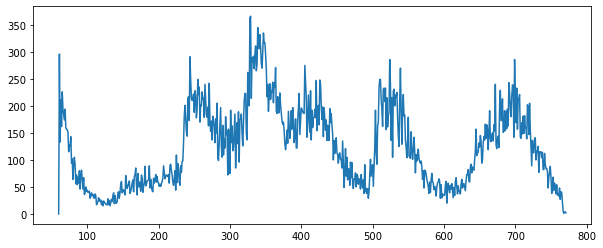

In [8]:
dfUCI.iloc[60:,1].plot(figsize=(10,4))

In [18]:
#Merge, remove null and na imputation

In [ ]:
#Risk

In [7]:
today = "2021-04-09"#""2021-02-04" #"2021-01-26"

In [8]:
dfInRisk = pd.read_csv("data_flow/inrisk_CAT_" + today +".csv")

for i,col in enumerate(dfInRisk.columns):
    if i==0:
        dfInRisk[col] = pd.to_datetime(dfInRisk[col])
    else:
        dfInRisk[col] = pd.to_numeric(dfInRisk[col])

dfInRisk.sort_values("date",ascending=True, inplace=True)
dfInRisk["risk_BCN"] = dfInRisk["inrisk_08"]
dfInRisk["risk_GI"] = dfInRisk["inrisk_17"]
dfInRisk["risk_TAR"] = dfInRisk["inrisk_43"]
dfInRisk["risk_LLE"] = dfInRisk["inrisk_25"]
dfInRisk = dfInRisk[["date","risk_BCN","risk_GI","risk_LLE","risk_TAR"]]

print(dfInRisk.shape)
print(dfInRisk.columns)
print(dfInRisk["date"].iloc[:5])

(398, 5)
Index(['date', 'risk_BCN', 'risk_GI', 'risk_LLE', 'risk_TAR'], dtype='object')
0   2020-02-15
1   2020-02-16
2   2020-02-17
3   2020-02-18
4   2020-02-19
Name: date, dtype: datetime64[ns]


In [9]:
# calculate cases by computing the mean of the last 7 days reported cases
cols = dfInRisk.columns
print(cols)
for k in range(1,len(cols)):
    zn = []
    for i in range(dfInRisk.shape[0]):
        acc = 0
        for j in range(7):
            if i-j>=0:
                acc += dfInRisk.iloc[i-j,k]
        zn.append(acc/7)

    dfInRisk[cols[k] + "_7"] = zn
    
    #plot
    #plt.figure(figsize=(10,4))    
    #ax = plt.subplot(1,2,1)
    #dfInRisk[["mean"]].plot(ax=ax)
    #ax = plt.subplot(1,2,2)
    #dfInRisk[["mean_7"]].plot(ax=ax)    
    #plt.show()
    #break
    
dfInRisk = dfInRisk[["date","risk_BCN_7","risk_GI_7","risk_LLE_7","risk_TAR_7"]]
dfInRisk

Index(['date', 'risk_BCN', 'risk_GI', 'risk_LLE', 'risk_TAR'], dtype='object')


,date,risk_BCN_7,risk_GI_7,risk_LLE_7,risk_TAR_7
0,2020-02-15,0.072949,0.151855,0.043482,0.102327
1,2020-02-16,0.143009,0.275563,0.075502,0.181203
2,2020-02-17,0.209083,0.381742,0.108660,0.260290
3,2020-02-18,0.279912,0.493185,0.143284,0.343318
4,2020-02-19,0.354539,0.602402,0.179170,0.428768
...,...,...,...,...,...
393,2021-03-15,233.210782,139.892285,68.357402,106.818405
394,2021-03-16,236.485094,141.624650,68.076668,107.634371
395,2021-03-17,239.198669,142.814572,67.596189,107.492742
396,2021-03-18,243.290157,144.225753,67.145308,108.536820


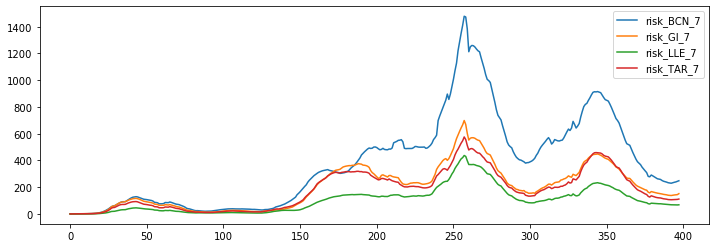

In [10]:
dfInRisk[["risk_BCN_7","risk_GI_7","risk_LLE_7","risk_TAR_7"]].plot(figsize=(12,4))
plt.show()

In [11]:
#Cases

In [12]:
dfCases = pd.read_csv("data_flow/cases_CAT_" + today + ".csv")
dfCases["date"] = pd.to_datetime(dfCases["date"])
dfCases.sort_values("date",ascending=True, inplace=True)

#Aggregate
dfCases["new_cases"] = np.nansum(dfCases[['new_cases_BCN','new_cases_GI',
                                          'new_cases_TAR',"new_cases_LLE"]],axis=1)
#dfCases["new_cases_mean"] = np.nanmean(dfCases[['new_cases_BCN', 'new_cases_GI', 'new_cases_TAR']], axis=1)
#dfCases["new_cases_std"] = np.nanstd(dfCases[['new_cases_BCN', 'new_cases_GI', 'new_cases_TAR']], axis=1)
#dfCases["new_cases_min"] = np.nanmin(dfCases[['new_cases_BCN', 'new_cases_GI', 'new_cases_TAR']], axis=1)
#dfCases["new_cases_max"] = np.nanmax(dfCases[['new_cases_BCN', 'new_cases_GI', 'new_cases_TAR']], axis=1)

dfCases = dfCases[["date","new_cases","new_cases_BCN","new_cases_GI","new_cases_TAR","new_cases_LLE"]]
dfCases["total_cases"] = np.cumsum(dfCases["new_cases"].values)
print(dfCases.shape,dfCases.columns)

(464, 7) Index(['date', 'new_cases', 'new_cases_BCN', 'new_cases_GI', 'new_cases_TAR',
       'new_cases_LLE', 'total_cases'],
      dtype='object')


In [13]:
cols = dfCases.columns
for k in range(1,len(cols)):
    zn = []
    for i in range(dfCases.shape[0]):
        acc = 0
        for j in range(7):
            if i-j>=0:
                acc += dfCases.iloc[i-j,k]
        zn.append(acc/7)

    dfCases[cols[k] + "_7"] = zn

dfCases

,date,new_cases,new_cases_BCN,new_cases_GI,new_cases_TAR,new_cases_LLE,total_cases,new_cases_7,new_cases_BCN_7,new_cases_GI_7,new_cases_TAR_7,new_cases_LLE_7,total_cases_7
0,2020-01-01,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2020-01-02,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2020-01-03,1,0,0,0,1,1,0.142857,0.000000,0.000000,0.000000,0.142857,0.142857
3,2020-01-04,0,0,0,0,0,1,0.142857,0.000000,0.000000,0.000000,0.142857,0.285714
4,2020-01-05,0,0,0,0,0,1,0.142857,0.000000,0.000000,0.000000,0.142857,0.428571
...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,2021-04-04,339,204,43,41,51,537934,900.714286,641.428571,103.857143,52.571429,102.857143,536045.142857
460,2021-04-05,217,130,29,22,36,538151,721.857143,504.428571,85.571429,46.714286,85.142857,536767.000000
461,2021-04-06,171,127,34,4,6,538322,560.857143,384.857143,67.857143,38.857143,69.285714,537327.857143
462,2021-04-07,0,0,0,0,0,538322,391.857143,264.285714,46.428571,29.142857,52.000000,537719.714286


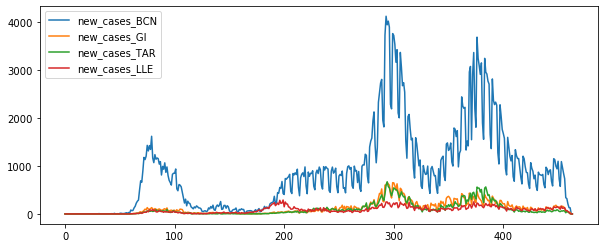

In [14]:
dfCases[["new_cases_BCN","new_cases_GI","new_cases_TAR","new_cases_LLE"]].plot(figsize=(10,4))
plt.show()

Index(['date', 'uci'], dtype='object')


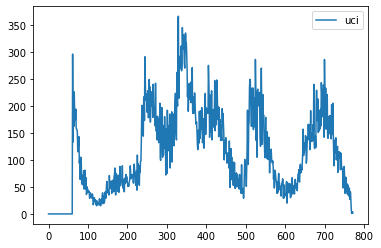

In [15]:
dfUCI = pd.read_csv("data_flow/UCI_CAT_OCU" + today +".csv")
print(dfUCI.columns)
dfUCI.plot()
dfUCI["date"] = pd.to_datetime(dfUCI["date"])

In [16]:
dfUCI['uci'][dfUCI["date"]<="2021-01-19"].sum()

26675

In [18]:
cols = dfUCI.columns
for k in range(1,len(cols)):
    zn = []
    for i in range(dfUCI.shape[0]):
        acc = 0
        for j in range(7):
            if i-j>=0:
                acc += dfUCI.iloc[i-j,k]
        zn.append(acc/7)

    dfUCI[cols[k] + "_7"] = zn

dfUCI

,date,uci,uci_7
0,2020-03-01,0,0.000000
1,2020-03-02,0,0.000000
2,2020-03-03,0,0.000000
3,2020-03-04,0,0.000000
4,2020-03-05,0,0.000000
...,...,...,...
767,2022-04-07,6,31.142857
768,2022-04-08,1,26.571429
769,2022-04-09,3,20.142857
770,2022-04-10,4,16.857143


In [19]:
#Merge cases
dfAll = pd.merge(dfCases[["date","new_cases","total_cases","new_cases_7",
                         "new_cases_GI_7","new_cases_LLE_7","new_cases_BCN_7","new_cases_TAR_7"]],
                 dfInRisk[["date","risk_BCN_7","risk_GI_7","risk_LLE_7","risk_TAR_7"]], 
                 how="left",on="date")
dfAll["date"] = pd.to_datetime(dfAll["date"])

#Merge with UCI
dfAll = pd.merge(dfAll, dfUCI, how="left",on="date")
dfAll["date"] = pd.to_datetime(dfAll["date"])
dfAll["uci"] = pd.to_numeric(dfAll["uci"])
dfAll["uci_7"] = pd.to_numeric(dfAll["uci_7"])
print(dfAll.shape)
print(dfAll.isnull().sum())
dfAll

(464, 14)
date                0
new_cases           0
total_cases         0
new_cases_7         0
new_cases_GI_7      0
new_cases_LLE_7     0
new_cases_BCN_7     0
new_cases_TAR_7     0
risk_BCN_7         66
risk_GI_7          66
risk_LLE_7         66
risk_TAR_7         66
uci                60
uci_7              60
dtype: int64


,date,new_cases,total_cases,new_cases_7,new_cases_GI_7,new_cases_LLE_7,new_cases_BCN_7,new_cases_TAR_7,risk_BCN_7,risk_GI_7,risk_LLE_7,risk_TAR_7,uci,uci_7
0,2020-01-01,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-02,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-03,1,1,0.142857,0.000000,0.142857,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-04,0,1,0.142857,0.000000,0.142857,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-05,0,1,0.142857,0.000000,0.142857,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,2021-04-04,339,537934,900.714286,103.857143,102.857143,641.428571,52.571429,NaN,NaN,NaN,NaN,173.0,165.142857
460,2021-04-05,217,538151,721.857143,85.571429,85.142857,504.428571,46.714286,NaN,NaN,NaN,NaN,196.0,175.714286
461,2021-04-06,171,538322,560.857143,67.857143,69.285714,384.857143,38.857143,NaN,NaN,NaN,NaN,194.0,186.000000
462,2021-04-07,0,538322,391.857143,46.428571,52.000000,264.285714,29.142857,NaN,NaN,NaN,NaN,189.0,188.285714


In [20]:
#Remove days without mobility index 
dfAll = dfAll.iloc[121:]

#Remove last day 
dfAll = dfAll.iloc[:-20]#20

dfAll.reset_index(inplace=True, drop=True)

#Na inputation
dfAll.interpolate(method='linear', limit_direction='forward', axis=0, inplace=True, order=2)

print(dfAll.shape)
print(dfAll.isnull().sum())
dfAll.head()

(323, 14)
date               0
new_cases          0
total_cases        0
new_cases_7        0
new_cases_GI_7     0
new_cases_LLE_7    0
new_cases_BCN_7    0
new_cases_TAR_7    0
risk_BCN_7         0
risk_GI_7          0
risk_LLE_7         0
risk_TAR_7         0
uci                0
uci_7              0
dtype: int64


,date,new_cases,total_cases,new_cases_7,new_cases_GI_7,new_cases_LLE_7,new_cases_BCN_7,new_cases_TAR_7,risk_BCN_7,risk_GI_7,risk_LLE_7,risk_TAR_7,uci,uci_7
0,2020-05-01,189,49534,168.428571,16.000000,7.142857,138.428571,6.857143,41.876599,28.807641,10.571650,21.095170,296.0,42.285714
1,2020-05-02,158,49692,164.571429,17.000000,5.571429,135.000000,7.000000,39.040989,26.829720,10.105767,19.853923,133.0,61.285714
2,2020-05-03,141,49833,164.571429,18.142857,5.000000,134.571429,6.857143,37.245146,25.598914,9.889978,19.233542,211.0,91.428571
3,2020-05-04,137,49970,164.857143,17.428571,6.571429,134.857143,6.000000,33.360169,22.921149,9.345424,17.380024,162.0,114.571429
4,2020-05-05,75,50045,149.142857,14.571429,6.285714,122.000000,6.285714,29.748058,20.915525,8.762092,15.776784,226.0,146.857143


(310, 14)
Index(['var1(t-7)', 'var1(t-6)', 'var1(t-5)', 'var1(t-4)', 'var1(t-3)',
       'var1(t-2)', 'var1(t-1)', 'var1(t)', 'var1(t+1)', 'var1(t+2)',
       'var1(t+3)', 'var1(t+4)', 'var1(t+5)', 'var1(t+6)'],
      dtype='object')
TR: 279 TS: 31


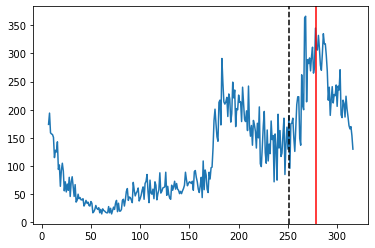

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
307,211.0,187.0,224.0,202.0,188.0,172.0,166.0
308,187.0,224.0,202.0,188.0,172.0,166.0,170.0
309,224.0,202.0,188.0,172.0,166.0,170.0,154.0
310,202.0,188.0,172.0,166.0,170.0,154.0,130.0
311,188.0,172.0,166.0,170.0,154.0,130.0,119.0
312,172.0,166.0,170.0,154.0,130.0,119.0,132.0
313,166.0,170.0,154.0,130.0,119.0,132.0,155.0
314,170.0,154.0,130.0,119.0,132.0,155.0,131.0
315,154.0,130.0,119.0,132.0,155.0,131.0,190.0
316,130.0,119.0,132.0,155.0,131.0,190.0,166.0


In [21]:
#Convert data to format (rows,timepoints,features)
cols = [
         #'total_cases',
         #'new_cases',
         #'new_cases_7',
         #'new_cases_GI_7',
         #'new_cases_TAR_7',
         #'new_cases_BCN_7',
         #'new_cases_LLE_7',    
         #'risk_BCN_7',
         #'risk_GI_7',
         #'risk_LLE_7',
         #'risk_TAR_7',
         #'uci_7',
         'uci'
]
res = series_to_supervised(dfAll.loc[:,cols].values,7,7)
print(res.shape)
print(res.columns)

THR_VAL = int(res.shape[0]*0.1)
THR = int(res.shape[0]-THR_VAL)
print("TR:",THR,"TS:",THR_VAL)

plt.plot(res["var1(t)"])
plt.axvline(THR,c="r")
plt.axvline(int(THR-(THR*0.10)),c="black", ls="--")
plt.show()
res.iloc[-10:,[(7*len(cols))+(i*len(cols)) for i in range(7)]]

In [22]:
#Patition train/test
print(len(cols))
train_X = res.iloc[:THR,:len(cols)*7].values.reshape(-1,7,len(cols))
train_y = res.iloc[:THR,[((len(cols)*7)+len(cols))+(len(cols)*i)-1 for i in range(7)]].values.reshape(-1,7)
test_X = res.iloc[THR:,:len(cols)*7].values.reshape(-1,7,len(cols))
test_y = res.iloc[THR:,[((len(cols)*7)+len(cols))+(len(cols)*i)-1 for i in range(7)]].values.reshape(-1,7)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

1
(279, 7, 1) (279, 7) (31, 7, 1) (31, 7)


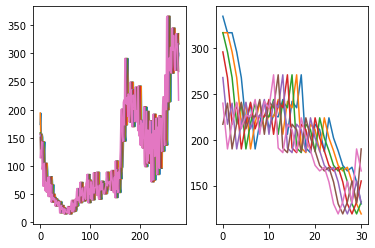

In [23]:
ax=plt.subplot(1,2,1)
ax.plot(range(len(train_y)),train_y)
ax=plt.subplot(1,2,2)
ax.plot(range(len(test_y)),test_y)
plt.show()

In [24]:
fname = "best_model_uci_CAT_7to21ahead_1_ocu_fixed.base"

In [25]:
from pickle import dump

# normalize features
scalers_X = []
for i in range(train_X.shape[-1]):

    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_X[:,:,i] = scaler.fit_transform(train_X[:,:,i])
    test_X[:,:,i] = scaler.transform(test_X[:,:,i])
    scalers_X.append(scaler)
    dump(scaler, open("models/"+ fname + "_scaler_tr_X_" + str(i)+'.pkl', 'wb'))
    
scaler_y = MinMaxScaler(feature_range=(0, 1))
train_y = scaler_y.fit_transform(train_y.reshape(-1,7))
test_y = scaler_y.transform(test_y.reshape(-1,7))
dump(scaler_y, open("models/"+ fname + "_scaler_tr_Y.pkl", 'wb'))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(279, 7, 1) (279, 7) (31, 7, 1) (31, 7)


In [37]:
scaler_y.inverse_transform(train_y)[:5]

array([[105.,  91.,  56.,  72.,  54.,  68.,  57.,  80.,  46.,  72.,  81.,
         64.,  46.,  67.,  36.,  39.,  50.,  42.,  44.,  40.,  40.],
       [ 91.,  56.,  72.,  54.,  68.,  57.,  80.,  46.,  72.,  81.,  64.,
         46.,  67.,  36.,  39.,  50.,  42.,  44.,  40.,  40.,  42.],
       [ 56.,  72.,  54.,  68.,  57.,  80.,  46.,  72.,  81.,  64.,  46.,
         67.,  36.,  39.,  50.,  42.,  44.,  40.,  40.,  42.,  29.],
       [ 72.,  54.,  68.,  57.,  80.,  46.,  72.,  81.,  64.,  46.,  67.,
         36.,  39.,  50.,  42.,  44.,  40.,  40.,  42.,  29.,  33.],
       [ 54.,  68.,  57.,  80.,  46.,  72.,  81.,  64.,  46.,  67.,  36.,
         39.,  50.,  42.,  44.,  40.,  40.,  42.,  29.,  33.,  39.]])

In [38]:
#Model

In [26]:
# fit network
bs=4
history=[]
min_tr = []
min_val = []
for i in range(5):
    print("Model:",i)
    model = keras.Sequential()
    model.add(keras.layers.LSTM(50, activation="relu",
                                input_shape=(train_X.shape[1], train_X.shape[2]),recurrent_dropout=0.3))
                                #return_sequences=True))                            
    #model.add(keras.layers.LSTM(50))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(7))
    opt = keras.optimizers.Adam(learning_rate=0.0001) 
    model.compile(loss='mean_squared_error', optimizer=opt,metrics=["mae"])
    
    # design callbacks
    es = keras.callbacks.EarlyStopping(monitor='val_mae', 
                                       verbose=1, patience=50)
    mc = keras.callbacks.ModelCheckpoint("models/"+ fname + "_" + str(i) +'.h5', 
                                         monitor='val_mae', 
                                         verbose=0, save_best_only=True)

    history.append(model.fit(train_X, train_y, epochs=500, batch_size=bs, 
                        callbacks=[es,mc],
                        validation_split=0.10, verbose=0, shuffle=False))
    
    ix = np.argmin(history[-1].history.get('val_mae'))
    min_val.append(history[-1].history.get('val_mae')[ix])
    min_tr.append(history[-1].history.get('mae')[ix])
    print("MAE:",min_tr[-1], min_val[-1], ix)

Model: 0
Epoch 00186: early stopping
MAE: 0.0686412900686264 0.14269301295280457 135
Model: 1
Epoch 00331: early stopping
MAE: 0.06522832065820694 0.13435059785842896 280
Model: 2
Epoch 00340: early stopping
MAE: 0.06381258368492126 0.13441739976406097 289
Model: 3
Epoch 00373: early stopping
MAE: 0.06224043667316437 0.13611552119255066 322
Model: 4
Epoch 00399: early stopping
MAE: 0.06425047665834427 0.12974213063716888 348


In [27]:
print("\nMIN TR:",np.mean(min_tr),np.std(min_tr))
print("MIN VAL:",np.mean(min_val),np.std(min_val))


MIN TR: 0.06483462154865265 0.002133602869599175
MIN VAL: 0.1354637324810028 0.004189461377465001


dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])
MAE VALSET: 0 0.056789692
MAE VALSET: 1 0.057788037
MAE VALSET: 2 0.058334965
MAE VALSET: 3 0.05513564
MAE VALSET: 4 0.06764703
MAE VALSET: 5 0.06301127
MAE VALSET: 6 0.056811687
MAE VALSET: 7 0.06258603
MAE VALSET: 8 0.06033596
MAE VALSET: 9 0.053512458
MAE VALSE (MEAN): 0.059195273


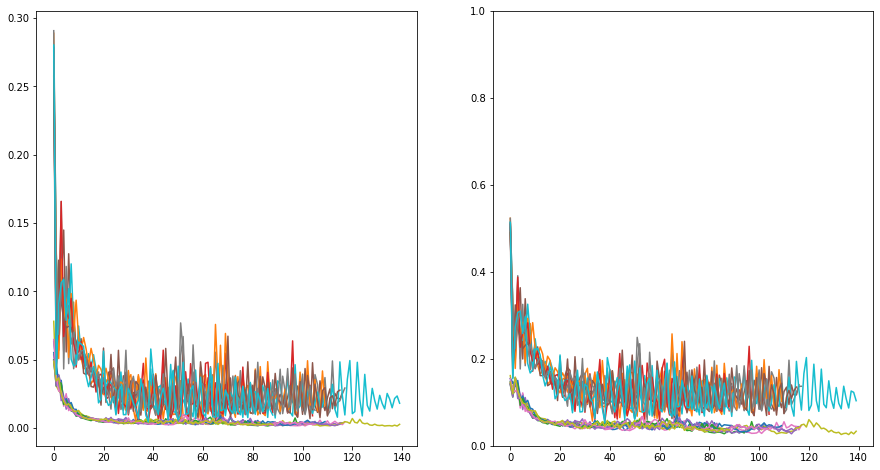

In [60]:
# plot history
plt.figure(figsize=(15,8))
ax = plt.subplot(1,2,1)

print(history[0].history.keys())

mins = []
for i in range(len(history)):
    mins.append(np.min(history[i].history.get('val_mean_absolute_error')))
    print("MAE VALSET:", i,np.min(history[i].history.get('val_mean_absolute_error')))
    ax.plot(history[i].history['loss'], label='train')
    ax.plot(history[i].history['val_loss'], label='test')
print("MAE VALSE (MEAN):", np.mean(mins))

ax = plt.subplot(1,2,2)
for i in range(len(history)):
    ax.plot(history[i].history['mean_absolute_error'], label='train')
    ax.plot(history[i].history['val_mean_absolute_error'], label='test')
plt.ylim(0,1.)
plt.show()

#0.0605

In [61]:
print("Loading...", fname)
model = tf.keras.models.load_model("models/"+ fname + "_" + str(9) +'.h5')

Loading... best_model_uci_CAT_7to21ahead_1_ocu_fixed


In [ ]:
#retrain
#history = model.fit(train_X[278:,:,:], train_y[278:], epochs=5, batch_size=bs, 
#                    verbose=1, shuffle=False)

(249, 21)
(249, 21)


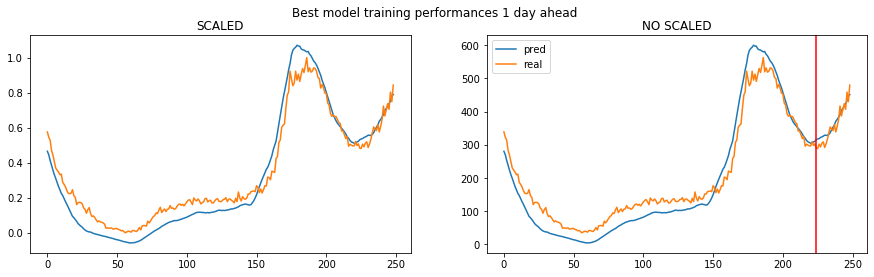

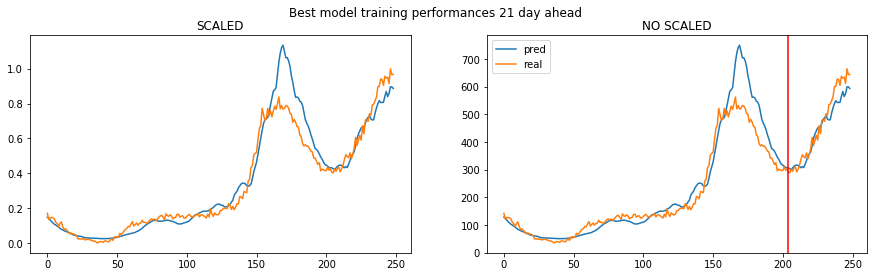

In [62]:
tr = model.predict(train_X)
print(tr.shape)
tr_y_pred = scaler_y.inverse_transform(tr)
tr_y_real = scaler_y.inverse_transform(train_y)
print(tr_y_real.shape)

for i in [0,20]:
    fig = plt.figure(figsize=(15,4))
    ax = plt.subplot(1,2,1)
    ax.plot(range(len(tr)),tr[:,i], label="pred")
    ax.plot(range(len(tr)),train_y[:,i],label="real")
    ax.set_title("SCALED")
    ax = plt.subplot(1,2,2)
    ax.plot(range(len(tr)),tr_y_pred[:,i], label="pred")
    ax.plot(range(len(tr)),tr_y_real[:,i],label="real")
    ax.set_title("NO SCALED")
    ax.axvline(int(THR-(THR*0.1)-i),c="r")
    plt.legend()
    plt.suptitle("Best model training performances {} day ahead".format(i+1))
    plt.show()

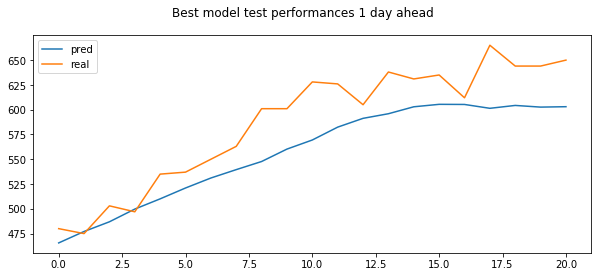

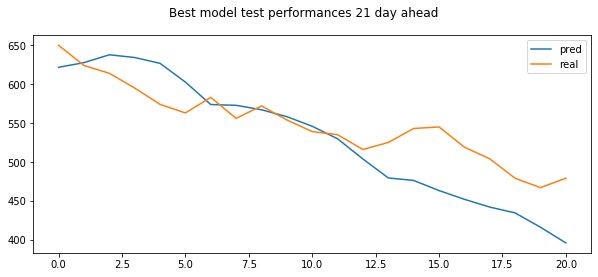

In [63]:
ts = model.predict(test_X)
ts_y_pred = scaler_y.inverse_transform(ts)
ts_y_real = scaler_y.inverse_transform(test_y)

for i in [0,20]:
    plt.figure(figsize=(10,4))
    ax = plt.subplot(1,1,1)
    ax.plot(range(len(ts_y_pred)),ts_y_pred[:,i], label="pred")
    ax.plot(range(len(ts_y_real)),ts_y_real[:,i],label="real")
    plt.suptitle("Best model test performances {} day ahead".format(i+1))
    plt.legend()
    plt.show()

In [64]:
from sklearn import metrics
print(ts_y_real.shape, ts_y_pred.shape)
maes = []
rmse = []
mapes = []
r2s = []
for i in range(21):
    maes.append(metrics.mean_absolute_error(ts_y_real[i,:], ts_y_pred[i,:]))
    rmse.append(np.sqrt(metrics.mean_squared_error(ts_y_real[i,:], ts_y_pred[i,:])))
    mapes.append(metrics.mean_absolute_percentage_error(ts_y_real[i,:], ts_y_pred[i,:]))
    r2s.append(metrics.r2_score(ts_y_real[i,:], ts_y_pred[i,:]))
    print("Forecast serie :", i, "(of 21 days)")
    print('Test mean absolute error (mae): {}'.format(maes[-1]))
    print('Test mean absolute perc. error (mape): {}'.format(mapes[-1]))
    print('Test r^2: {}'.format(r2s[-1]))

(21, 21) (21, 21)
Forecast serie : 0 (of 21 days)
Test mean absolute error (mae): 30.369143531436016
Test mean absolute perc. error (mape): 0.051011132570037324
Test r^2: 0.6556794525214398
Forecast serie : 1 (of 21 days)
Test mean absolute error (mae): 26.82321021670388
Test mean absolute perc. error (mape): 0.04399870109487539
Test r^2: 0.5786228059843002
Forecast serie : 2 (of 21 days)
Test mean absolute error (mae): 25.191702706473215
Test mean absolute perc. error (mape): 0.04176446837843687
Test r^2: 0.5937154215793421
Forecast serie : 3 (of 21 days)
Test mean absolute error (mae): 29.753436860584078
Test mean absolute perc. error (mape): 0.04873155314620944
Test r^2: 0.3334115725361424
Forecast serie : 4 (of 21 days)
Test mean absolute error (mae): 31.541309175037206
Test mean absolute perc. error (mape): 0.052008829607994835
Test r^2: 0.03568563548322745
Forecast serie : 5 (of 21 days)
Test mean absolute error (mae): 39.491290864490345
Test mean absolute perc. error (mape): 0.0

In [65]:
print("Prediction test results of infected cases:")
print("MAE  :", np.mean(maes).round(2),"+/-", np.std(maes).round(2))
print("RMSE :", np.mean(rmse).round(2),"+/-", np.std(rmse).round(2))
print("MAPE :", np.mean(mapes).round(2), "+/-", np.std(mapes).round(2))
print("R2   :", np.mean(r2s).round(2), "+/-", np.std(r2s).round(2))

Prediction test results of infected cases:
MAE  : 38.44 +/- 6.15
RMSE : 44.98 +/- 6.49
MAPE : 0.06 +/- 0.01
R2   : -0.36 +/- 0.77


In [166]:
#Cumulative


Cumulative prediction at: 0 day ahead
Incremento de casos en el período: 11840.0
Incremento predicho en el período: 11237.2734375
Diferencia de casos entre real y modelo en el período: 602.7265625
Risk ratio pred vs real: 0.9490940403293919
Risk ratio real vs pred: 1.0536363705886729

Cumulative prediction at: 1 day ahead
Incremento de casos en el período: 11989.0
Incremento predicho en el período: 10749.75390625
Diferencia de casos entre real y modelo en el período: 1239.24609375
Risk ratio pred vs real: 0.8966347406998082
Risk ratio real vs pred: 1.1152813454668475

Cumulative prediction at: 2 day ahead
Incremento de casos en el período: 12100.0
Incremento predicho en el período: 10699.94140625
Diferencia de casos entre real y modelo en el período: 1400.05859375
Risk ratio pred vs real: 0.8842926782024794
Risk ratio real vs pred: 1.1308473140733466

Cumulative prediction at: 3 day ahead
Incremento de casos en el período: 12198.0
Incremento predicho en el período: 11738.65625
Diferen

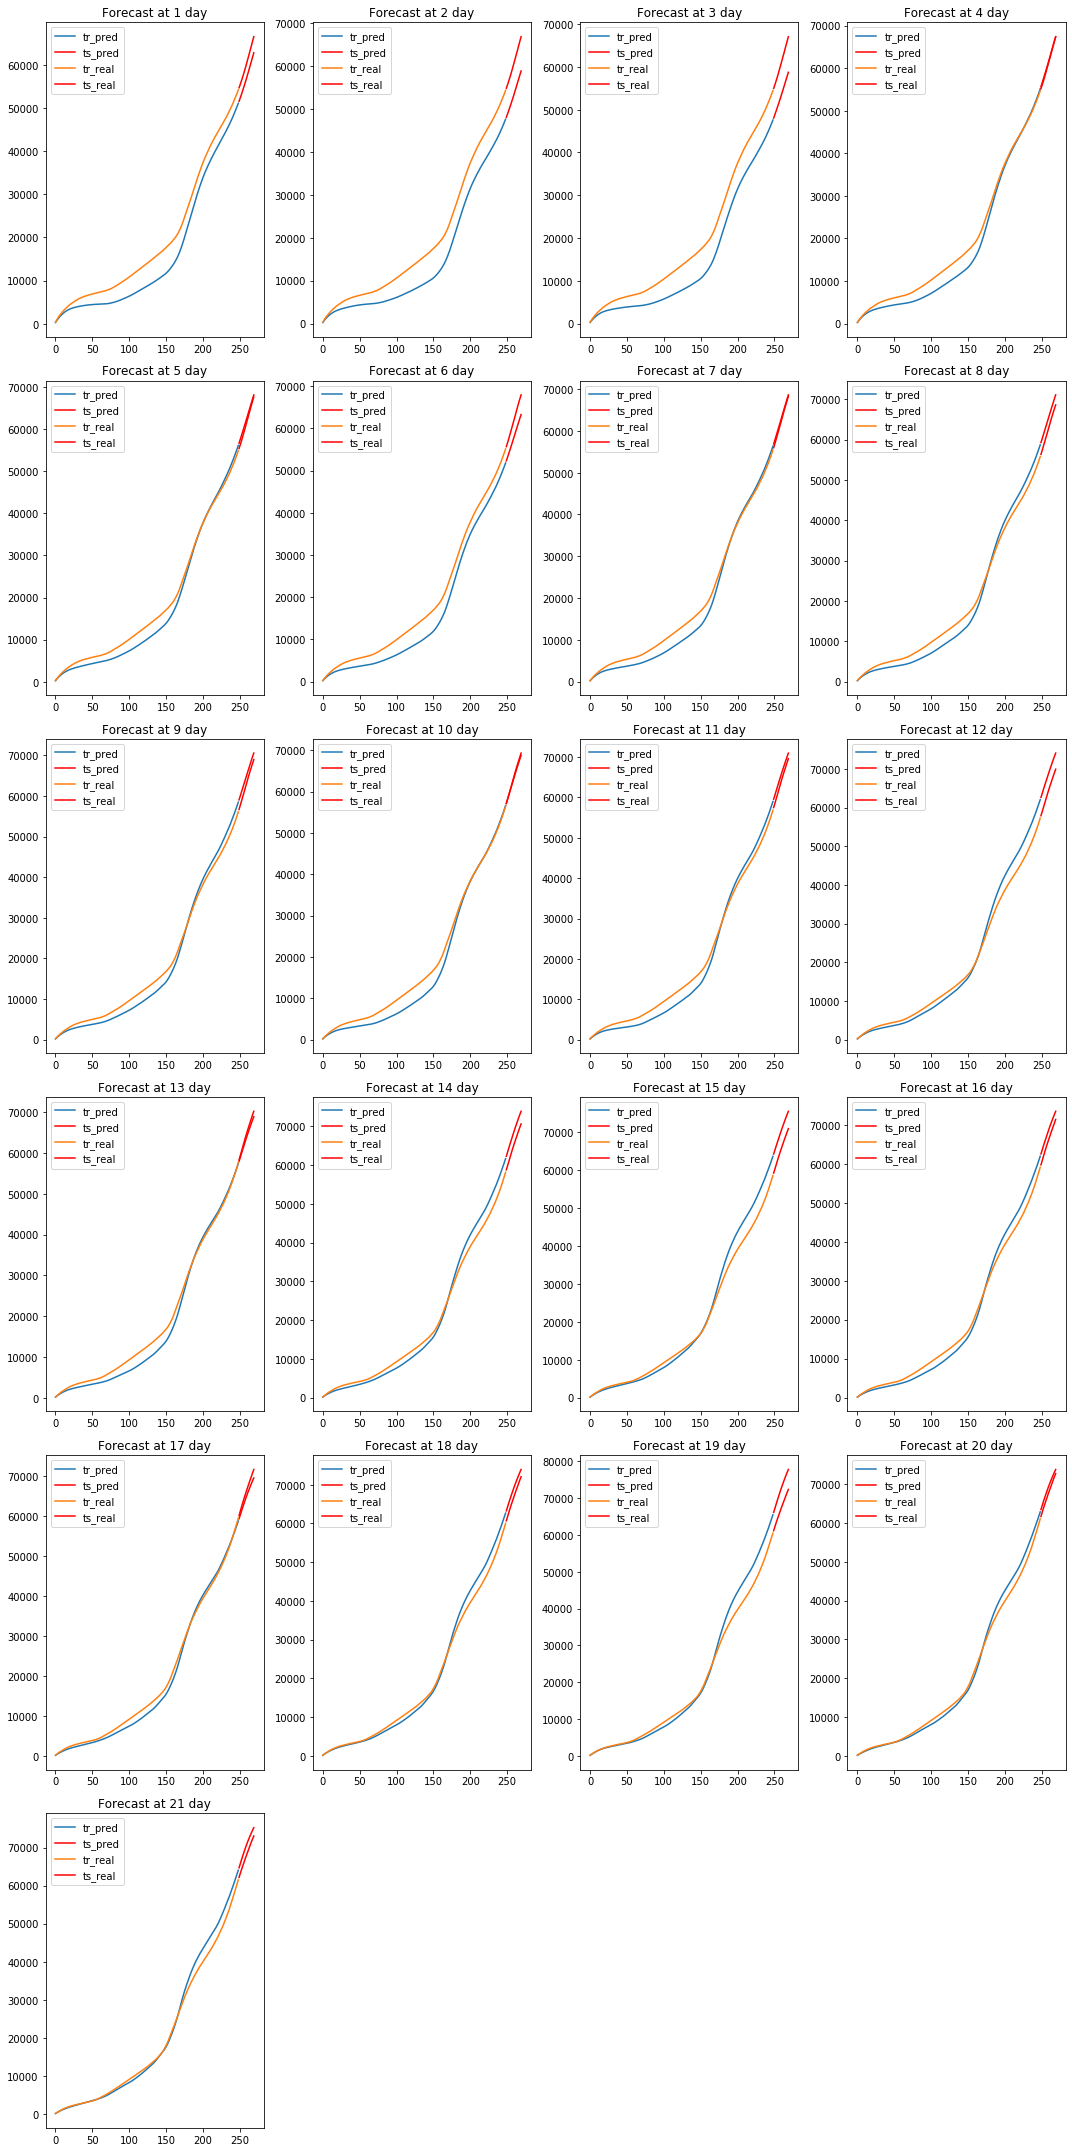

In [66]:
err_diffs = []
err_prs = []
err_rps = []

plt.figure(figsize=(15,30))
for i in range(21):
    
    y_pred = np.concatenate([tr_y_pred[:,i], ts_y_pred[:,i]])
    y_cum_pred = np.cumsum(y_pred)

    y_real = np.concatenate([tr_y_real[:,i], ts_y_real[:,i]])
    y_cum_real = np.cumsum(y_real)
    

    contador_pred = y_cum_pred[-1] - y_cum_pred[len(tr_y_pred)]
    err_diff = y_cum_real[-1] - y_cum_real[len(tr_y_pred)]- contador_pred
    
    print("\nCumulative prediction at:", i, "day ahead")
    print("Incremento de casos en el período: {}".format(y_cum_real[-1] - y_cum_real[len(tr_y_pred)]))
    print("Incremento predicho en el período: {}".format(y_cum_pred[-1] - y_cum_pred[len(tr_y_pred)]))
    print("Diferencia de casos entre real y modelo en el período: {}".format(err_diff))  
    
    err_pr = contador_pred / (y_cum_real[-1] - y_cum_real[len(tr_y_pred)])
    err_rp = (y_cum_real[-1] - y_cum_real[len(tr_y_pred)])/contador_pred
    print("Risk ratio pred vs real:", err_pr)
    print("Risk ratio real vs pred:", err_rp)
    
    err_diffs.append(err_diff)
    err_prs.append(err_pr)
    err_rps.append(err_rp)
    
    ax = plt.subplot(6,4,i+1)
    ax.plot(range(len(tr_y_pred)), y_cum_pred[:len(tr_y_pred)],label="tr_pred")
    ax.plot(range(len(tr_y_pred),len(tr_y_pred)+len(ts_y_pred)), y_cum_pred[len(tr_y_pred):], c="red",label="ts_pred")
    ax.plot(range(len(tr_y_real)), y_cum_real[:len(tr_y_pred)],label="tr_real")
    ax.plot(range(len(tr_y_real),len(tr_y_real)+len(ts_y_real)), y_cum_real[len(tr_y_pred):], c="red",label="ts_real")
    ax.set_title("Forecast at "+str(i+1)+ " day")
    ax.legend()

plt.tight_layout()
plt.show()

In [67]:
N=21
print("Rows:",len(err_diffs))
print("Daily cumulative diff error:", (np.mean(err_diffs)/N).round(2),
      "+/-",(np.std(err_diffs)/N).round(2))
print("Daily cumulative pred/real ratio error:", np.mean(err_prs).round(3),
      "+/-",np.std(err_prs).round(2))

Rows: 21
Daily cumulative diff error: 32.97 +/- 19.42
Daily cumulative pred/real ratio error: 0.942 +/- 0.03


In [ ]:
#Forecasting future!!

In [68]:
res_test = series_to_supervised(dfAll.loc[:,cols].values,7,21,dropnan=False)
print(cols)
res_test.shape

['new_cases', 'new_cases_7', 'new_cases_GI_7', 'new_cases_TAR_7', 'new_cases_BCN_7', 'new_cases_LLE_7', 'risk_BCN_7', 'risk_GI_7', 'risk_LLE_7', 'risk_TAR_7', 'uci']


(323, 308)

In [69]:
#Find rows for future pred
ftest_X = res_test.iloc[-1,:77].values.reshape(-1,7,11)
ftest_y = res_test.iloc[-1,[87+(11*i) for i in range(21)]].values.reshape(-1,21)

print(ftest_X.shape, ftest_y.shape)
print(ftest_y[0,:])

(1, 7, 11) (1, 21)
[346.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan]


In [70]:
from pickle import load

# normalize features
for i in range(ftest_X.shape[-1]):

    # normalize features
    scalers_X = load(open("models/"+ fname + "_scaler_tr_X_" + str(i)+'.pkl', 'rb'))

    ftest_X[:,:,i] = scalers_X.transform(ftest_X[:,:,i])
    print(i, ftest_X[:,:,i].max(), ftest_X[:,:,i].min())

print(ftest_X.shape)
print(np.nanmax(ftest_X),np.nanmin(ftest_X),np.nanmean(ftest_X),np.nanstd(ftest_X))

0 0.2271161863331521 0.12017400761283306
1 0.21178241238443343 0.18850016893448412
2 0.18340611353711794 0.14795787310557412
3 0.10163934426229508 0.07377049180327869
4 0.22005547617046314 0.2022778851811381
5 0.44660804020100503 0.3903810118675828
6 0.1532883287993647 0.14384458730267047
7 0.19164822086809788 0.18200849941669708
8 0.14855901448606396 0.14115358079079532
9 0.173378514916585 0.16901788221544484
10 0.6022727272727273 0.5606060606060607
(1, 7, 11)
0.6022727272727273 0.07377049180327869 0.22609874930819707 0.13707765139072695


In [121]:
#Forecasting last X days for all models

In [71]:
all_preds = []
for i in range(10):
    print("\nLoading model:", i)
    model = tf.keras.models.load_model("models/"+ fname + "_" + str(i) +'.h5')
    preds = model.predict(ftest_X)
    preds_inv = scaler_y.inverse_transform(preds)
    print(len(preds_inv), np.max(preds_inv), np.min(preds_inv))
    print(preds_inv.shape)
    all_preds.append(preds_inv)


Loading model: 0
1 304.68018 275.24832
(1, 21)

Loading model: 1
1 335.11923 286.75858
(1, 21)

Loading model: 2
1 302.9755 266.20578
(1, 21)

Loading model: 3
1 321.95078 265.14624
(1, 21)

Loading model: 4
1 333.30637 297.69565
(1, 21)

Loading model: 5
1 333.6381 275.33984
(1, 21)

Loading model: 6
1 333.34216 265.51382
(1, 21)

Loading model: 7
1 319.62332 282.2036
(1, 21)

Loading model: 8
1 298.0712 263.84494
(1, 21)

Loading model: 9
1 301.42517 262.6831
(1, 21)


In [72]:
all_preds_aux = np.stack((all_preds))
print(all_preds_aux.shape)

all_preds_aux[:,-1,:].mean(axis=0)
all_preds_aux[:,-1,:].std(axis=0)

(10, 1, 21)


array([15.596119 , 16.306639 , 15.741398 , 13.746665 , 13.405411 ,
       16.181078 , 12.55501  , 12.741372 ,  9.1422825, 10.608839 ,
       11.0802965, 11.296805 , 14.418241 , 10.960046 , 11.84992  ,
        9.912549 , 15.682457 , 12.58741  , 12.5070305, 12.749733 ,
       17.112343 ], dtype=float32)

In [73]:
all_res = all_preds_aux[:,:all_preds_aux.shape[1]]
for i in range(all_preds_aux.shape[1]-1,19,-1):
    all_res = np.hstack((all_preds_aux[:,i,-1].reshape(10,1),all_res))

all_res = np.array(all_res)
print(all_res.shape)

(10, 1, 21)


In [74]:
dfPreds = pd.DataFrame(np.hstack((all_res)).astype(int).reshape(10,21),
                       columns=["d"+str(i) for i in range(21)])
dfPreds.astype(int).to_csv("preds_icu_21days_7tp_"+today+".csv",index=False)
dfPreds.describe().T

,count,mean,std,min,25%,50%,75%,max
d0,10.0,294.4,16.453301,276.0,286.75,290.5,297.25,333.0
d1,10.0,287.9,17.226917,272.0,276.50,283.5,294.75,328.0
d2,10.0,287.7,16.660332,267.0,278.00,286.5,291.00,327.0
d3,10.0,284.2,14.619622,264.0,277.50,280.0,293.00,315.0
d4,10.0,283.8,14.045956,265.0,275.00,282.0,289.00,316.0
d5,10.0,284.3,16.839438,263.0,273.00,281.5,294.00,314.0
d6,10.0,280.0,13.148722,266.0,273.00,277.5,282.50,312.0
d7,10.0,282.9,13.378673,263.0,273.50,282.0,292.00,307.0
d8,10.0,283.0,9.533566,270.0,279.25,282.5,286.00,305.0
d9,10.0,282.2,11.193252,266.0,274.25,281.5,289.75,301.0


In [75]:
import datetime
import matplotlib.dates as mdates
date_time_str = '2021-03-19'
base = datetime.datetime.strptime(date_time_str, '%Y-%m-%d')
date_list = [base + datetime.timedelta(days=x) for x in range(21)]
date_list

[datetime.datetime(2021, 3, 19, 0, 0),
 datetime.datetime(2021, 3, 20, 0, 0),
 datetime.datetime(2021, 3, 21, 0, 0),
 datetime.datetime(2021, 3, 22, 0, 0),
 datetime.datetime(2021, 3, 23, 0, 0),
 datetime.datetime(2021, 3, 24, 0, 0),
 datetime.datetime(2021, 3, 25, 0, 0),
 datetime.datetime(2021, 3, 26, 0, 0),
 datetime.datetime(2021, 3, 27, 0, 0),
 datetime.datetime(2021, 3, 28, 0, 0),
 datetime.datetime(2021, 3, 29, 0, 0),
 datetime.datetime(2021, 3, 30, 0, 0),
 datetime.datetime(2021, 3, 31, 0, 0),
 datetime.datetime(2021, 4, 1, 0, 0),
 datetime.datetime(2021, 4, 2, 0, 0),
 datetime.datetime(2021, 4, 3, 0, 0),
 datetime.datetime(2021, 4, 4, 0, 0),
 datetime.datetime(2021, 4, 5, 0, 0),
 datetime.datetime(2021, 4, 6, 0, 0),
 datetime.datetime(2021, 4, 7, 0, 0),
 datetime.datetime(2021, 4, 8, 0, 0)]

In [76]:
dfPredsT = dfPreds.T
dfPredsT.reset_index(drop=True, inplace=True)
dfPredsT["date"] = date_list
#dfPredsT["date"] = pd.to_datetime(dfPredsT["date"])
#dfPredsT.index = dfPredsT["date"]
#dfPredsT = dfPredsT[[i for i in range(10)]]
dfPredsT.head()

,0,1,2,3,4,5,6,7,8,9,date
0,291,309,286,279,333,276,290,299,289,292,2021-03-19
1,278,298,285,272,328,284,273,302,283,276,2021-03-20
2,286,298,276,272,327,287,284,292,288,267,2021-03-21
3,277,296,280,271,315,279,280,284,264,296,2021-03-22
4,275,290,274,265,316,275,282,286,282,293,2021-03-23


In [77]:
print(dfPredsT[[i for i in range(10)]].mean(axis=1).mean(axis=0))
print(dfPredsT[[i for i in range(10)]].mean(axis=1).std(axis=0))

290.5
9.247648349715728


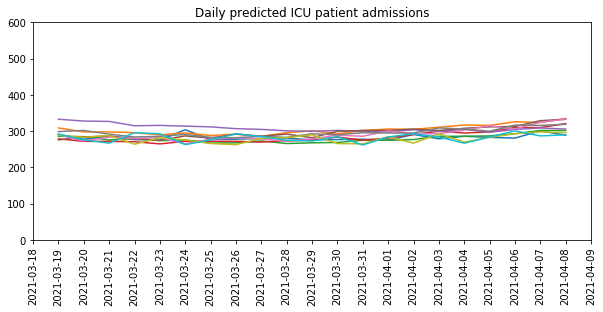

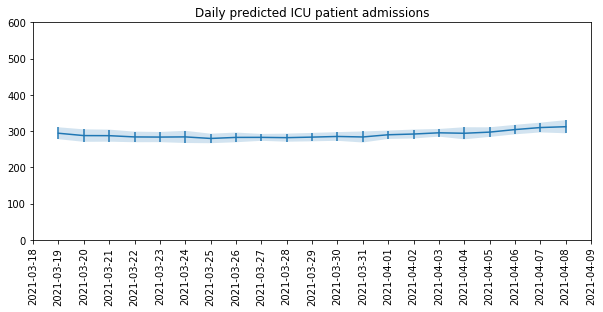

In [78]:
plt.figure(figsize=(10,4))
ax = plt.subplot(1,1,1)
ax.plot(dfPredsT["date"], dfPredsT[[i for i in range(10)]])
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.ylim(0,600)
plt.title("Daily predicted ICU patient admissions")
plt.xticks(rotation='vertical')
plt.show()

plt.figure(figsize=(10,4))
ax = plt.subplot(1,1,1)
ax.errorbar(dfPredsT["date"], 
            dfPredsT[[i for i in range(10)]].mean(axis=1),
            yerr=dfPredsT[[i for i in range(10)]].std(axis=1))
ax.fill_between(dfPredsT["date"],
                dfPredsT[[i for i in range(10)]].mean(axis=1)-dfPredsT[[i for i in range(10)]].std(axis=1),
                dfPredsT[[i for i in range(10)]].mean(axis=1)+dfPredsT[[i for i in range(10)]].std(axis=1),
                alpha=0.2)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.ylim(0,600)
plt.title("Daily predicted ICU patient admissions")
plt.xticks(rotation='vertical')
plt.show()

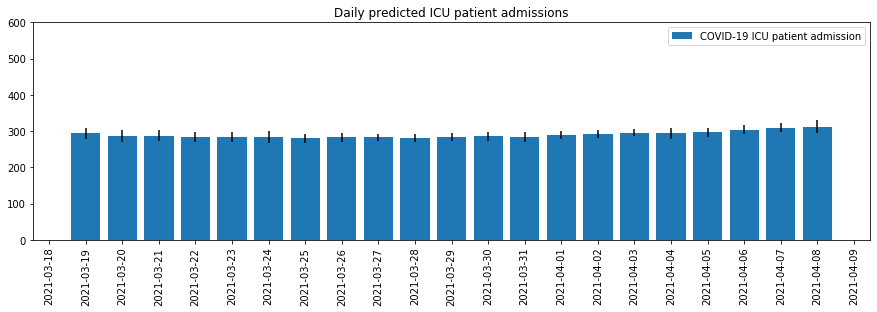

In [79]:
plt.figure(figsize=(15,4))
ax = plt.subplot(1,1,1)
ax.bar(dfPredsT["date"].values, np.mean(dfPredsT[[i for i in range(10)]], axis=1), 
            yerr=np.std(dfPredsT[[i for i in range(10)]], axis=1), label="COVID-19 ICU patient admission")
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.ylim(0,600)
plt.title("Daily predicted ICU patient admissions")
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

In [80]:
np.mean(dfPredsT[[i for i in range(10)]].cumsum(), axis=1)

0      294.4
1      582.3
2      870.0
3     1154.2
4     1438.0
5     1722.3
6     2002.3
7     2285.2
8     2568.2
9     2850.4
10    3134.1
11    3419.6
12    3703.7
13    3993.9
14    4286.1
15    4581.7
16    4876.0
17    5173.5
18    5478.0
19    5788.1
20    6100.5
dtype: float64

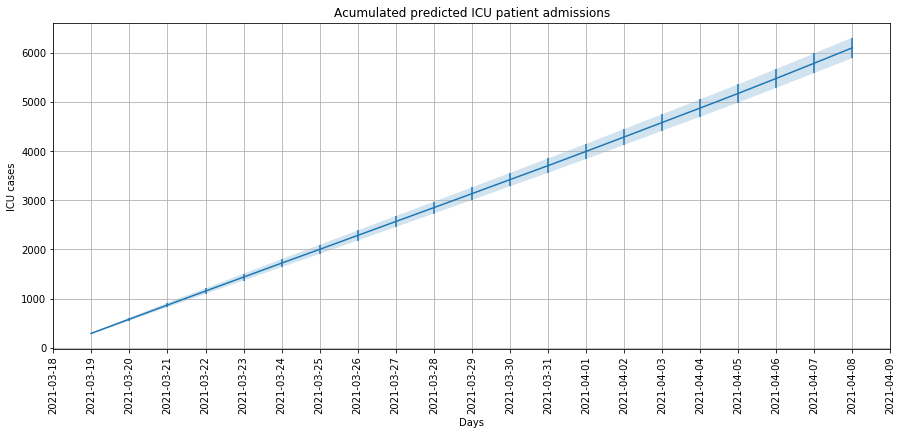

In [81]:
plt.figure(figsize=(15,6))
ax = plt.subplot(1,1,1)
ax.errorbar(dfPredsT["date"], np.mean(dfPredsT[[i for i in range(10)]].cumsum(), axis=1),
        yerr=np.std(dfPredsT[[i for i in range(10)]].cumsum(), axis=1))
ax.fill_between(dfPredsT["date"],
                np.mean(dfPredsT[[i for i in range(10)]].cumsum(), axis=1)-np.std(dfPredsT[[i for i in range(10)]].cumsum(), axis=1),
                np.mean(dfPredsT[[i for i in range(10)]].cumsum(), axis=1)+np.std(dfPredsT[[i for i in range(10)]].cumsum(), axis=1),
                alpha=0.2)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.title("Acumulated predicted ICU patient admissions")
plt.xticks(rotation='vertical')
plt.ylabel("ICU cases")
plt.xlabel("Days")
plt.grid()
plt.show()